## 3.	K-D trees και Quad Trees: Πειραματική Σύγκριση των δύο δομών (Storage/Build/Insert/Delete/Update/Search performance comparison) για 2 διαστάσεις. Υλοποίηση kNN Queries με τις παραπάνω δύο δομές και πειραματική σύγκριση.


In [ ]:
pip install astroML

     |████████████████████████████████| 112kB 12.0MB/s 
  Created wheel for astroML: filename=astroML-0.4.1-cp36-none-any.whl size=128665 sha256=018645157ad807e1ddd9df9e41e52b4add639c2de66aba841eec11a46ee600d1
  Stored in directory: /root/.cache/pip/wheels/7c/f2/f3/eb817cfb31b4445358dd7dda2434e02003f72801edabc38c97
Successfully built astroML


Στην εργασία θα συγκρίνουμε διαφορετικές υπολογιστικές λειτουργίες
τόσο για δέντρα K-D όσο και για τα Quad Trees. Οι μεταβλητές που θα
επηρεάσουν τον χρόνο υπολογισμού είναι οι εξής:

---


**- Ο αριθμός των σημείων** <br>
**- Η διάσταση των δεδομένων**<br>
**- Ο επιθυμητός αριθμός γειτόνων, k**<br>
**- Το μέγεθος κάθε φύλλου, leaf_size:** <br>
**- Η δομή των δεδομένων:** αν και η δομή και η διανομή δεδομένων δεν επηρεάζουν τα ερωτήματα brute-force, μπορούν να έχουν μεγάλο αντίκτυπο στους χρόνους ερωτήσεων των μεθόδων που βασίζονται σε δέντρα. 

In [ ]:
#for the viisualization
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
from scipy.spatial import cKDTree    #Quad Trees
from sklearn.neighbors import KDTree #K-D trees

### Data Sets

In [21]:
# Uniform random distribution
uniform_N = np.random.random((10000, 4))
uniform_D = np.random.random((1797, 128))

In [22]:
# Digits distribution
from sklearn.datasets import load_digits
digits = load_digits()
print (digits.images.shape)

(1797, 8, 8)


In [23]:
digits_N = np.vstack([digits.images[:, 2:4, 2:4],
                      digits.images[:, 2:4, 4:6],
                      digits.images[:, 4:6, 2:4],
                      digits.images[:, 4:6, 4:6],
                      digits.images[:, 4:6, 5:7],
                      digits.images[:, 5:7, 4:6]])
digits_N = digits_N.reshape((-1, 4))[:10000]

# Για τη δοκιμή διαστάσεων, χρειαζόμαστε έως και 128 διαστάσεις άρα θα
# συνδυάσουμε μερικές εικόνες

digits_D = np.hstack((digits.data,
                      np.vstack((digits.data[:1000], digits.data[1000:]))))
# τα pixels των άκρων είναι όλα 0

digits_D = np.hstack([digits_D[:, 28:], digits_D[:, :28]])

In [24]:
# προσθήκη φασμάτων από http://www.astroML.org
from astroML.datasets import fetch_sdss_corrected_spectra
spectra = fetch_sdss_corrected_spectra()['spectra']
spectra.shape

(4000, 1000)

In [25]:
spectra_N = np.vstack([spectra[:, 500:504],
                       spectra[:, 504:508],
                       spectra[:2000, 508:512]])
# επιλογή κεντρικής περιοχής των φασμάτων 
spectra_D = spectra[:1797, 400:528]

In [26]:
print (uniform_N.shape, uniform_D.shape)
print (digits_N.shape, digits_D.shape)
print (spectra_N.shape, spectra_D.shape)

(10000, 4) (1797, 128)
(10000, 4) (1797, 128)
(10000, 4) (1797, 128)


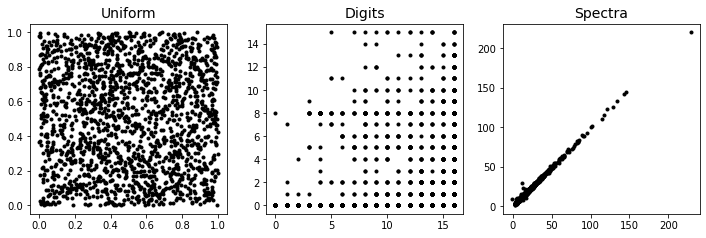

In [27]:
titles = ['Uniform', 'Digits', 'Spectra']
datasets_D = [uniform_D, digits_D, spectra_D]
datasets_N = [uniform_N, digits_N, spectra_N]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

for axi, title, dataset in zip(ax, titles, datasets_D):
    axi.plot(dataset[:, 1], dataset[:, 2], '.k')
    axi.set_title(title, size=14)

### Ανάπτυξη κώδικα για  πειραματική αξιολόγηση


In [ ]:
# synartisi ypologismou xronoy epeksergasias
from time import time
def average_time(executable, *args, **kwargs):
    """ypologismos mesoy xronoy """
    N = 5
    t = 0
    for i in range(N):
        t0 = time()
        res = executable(*args, **kwargs)
        t1 = time()
        t += (t1 - t0)
    return res, t * 1. / N

In [ ]:
#Main Fucntion
TREE_DICT = dict(cKDTree=cKDTree, KDTree=KDTree)
colors = dict(cKDTree='black', KDTree='red', brute='gray')

def bench_knn_query(tree_name, X, N, D, leaf_size, k,
                    build_args=None, query_args=None):
    """epanalipsi gia ton k-kontinotero geitona"""
    Tree = TREE_DICT[tree_name]
    
    if build_args is None:
        build_args = {}
        
    if query_args is None:
        query_args = {}
        
    NDLk = np.broadcast(N, D, leaf_size, k)
        
    t_build = np.zeros(NDLk.size)
    t_query = np.zeros(NDLk.size)
    
    for i, (N, D, leaf_size, k) in enumerate(NDLk):
        XND = X[:N, :D]
        
        if tree_name == 'cKDTree':
            build_args['leafsize'] = leaf_size
        else:
            build_args['leaf_size'] = leaf_size
        
        tree, t_build[i] = average_time(Tree, XND, **build_args)
        res, t_query[i] = average_time(tree.query, XND, k, **query_args)
        
    return t_build, t_query

In [ ]:
def plot_scaling(data, estimate_brute=False, suptitle='', **kwargs):
    """sxediash ths klimakwtis sugkrisis gia diaforetika dentra"""
    # Find the iterable key
    iterables = [key for (key, val) in kwargs.items() if hasattr(val, '__len__')]
    if len(iterables) != 1:
        raise ValueError("A single iterable argument must be specified")
    x_key = iterables[0]
    x = kwargs[x_key]
    
    # Set some defaults
    if 'N' not in kwargs:
        kwargs['N'] = data.shape[0]
    if 'D' not in kwargs:
        kwargs['D'] = data.shape[1]
    if 'leaf_size' not in kwargs:
        kwargs['leaf_size'] = 15
    if 'k' not in kwargs:
        kwargs['k'] = 5
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4),
                           subplot_kw=dict(yscale='log', xscale='log'))
        
    for tree_name in ['cKDTree', 'KDTree']:
        t_build, t_query = bench_knn_query(tree_name, data, **kwargs)
        if tree_name=='cKDTree':
          ax[0].plot(x, t_build, color=colors[tree_name], label='Quad Tree')
          ax[1].plot(x, t_query, color=colors[tree_name], label='Quad Tree')
        elif tree_name=='KDTree':
          ax[0].plot(x, t_build, color=colors[tree_name], label='K-D Tree')
          ax[1].plot(x, t_query, color=colors[tree_name], label='K-D Tree')
            
    for axi in ax:
        axi.grid(True)
        axi.set_xlabel(x_key)
        axi.set_ylabel('time (s)')
        axi.legend(loc='upper left')
        axi.set_xlim(np.min(x), np.max(x))
        
    info_str = ', '.join([key + '={' + key + '}' for key in ['N', 'D', 'k'] if key != x_key])
    ax[0].set_title('Tree Build Time ({0})'.format(info_str.format(**kwargs)))
    ax[1].set_title('Tree Query Time ({0})'.format(info_str.format(**kwargs)))
    
    if suptitle:
        fig.suptitle(suptitle, size=16)
    return fig, ax
    
    

### Σύγκριση των αποτελεσμάτων

**Κλιμάκωση ανάλογα το μέγεθος φύλλου**<br>


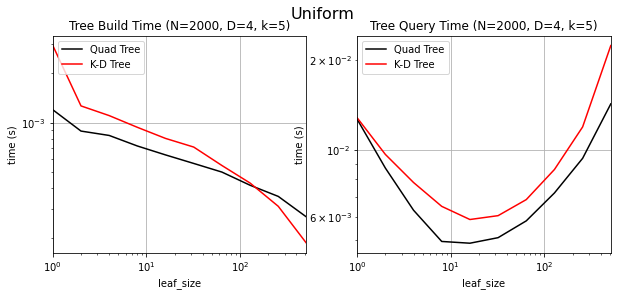

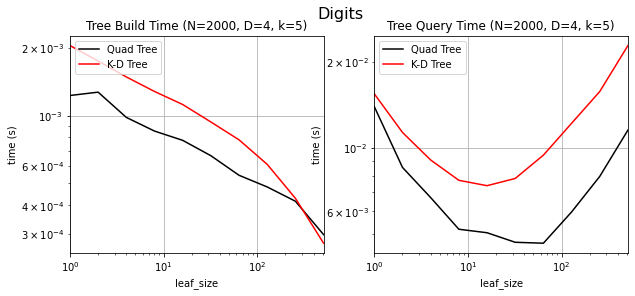

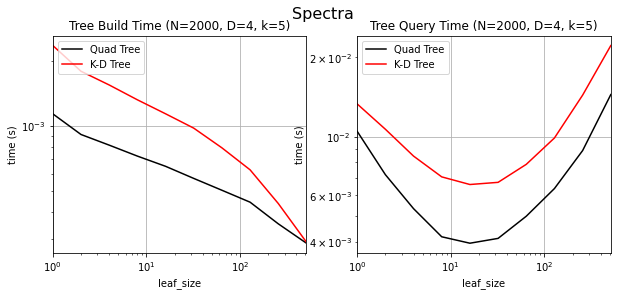

In [ ]:
leaf_size = 2 ** np.arange(10)
for title, dataset in zip(titles, datasets_N):
    fig, ax = plot_scaling(dataset, N=2000, leaf_size=leaf_size, suptitle=title)

* Με μεγαλύτερο μέγεθος φύλλου, ο χρόνος κατασκευής μειώνεται. Για πολύ μικρά μεγέθη φύλλων χρειάζεται περισσότερος χρόνος Το ίδιο ισχύει και πολύ μεγάλα μεγέθη φύλλων
* Παρατηρείται ότι τα Κ-D Trees χρειάζονται παραπάνω χρόνο από τα Quad Trees σε σχέση με τη δημιουργία και την εκτέλεση τους

**Κλιμάκωση με βάσω των αριθμό των γειτόνων**<br>
Εδώ θα αναπαραστεί η κλιμάκωση με βάση των αριθμών των γειτονικών k, όπου δεν επηρρεάζεται ο χρόνος κατασκευής αλλά ο χρόνος εκτέλεσης

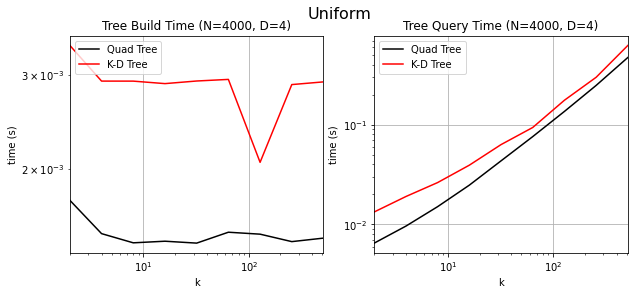

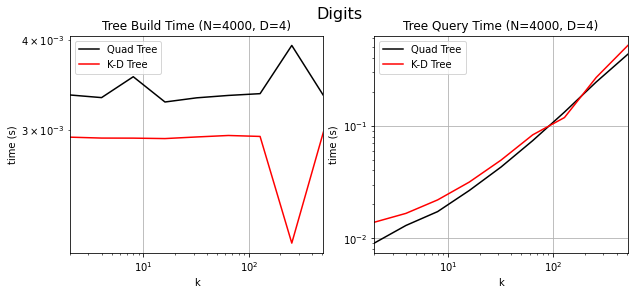

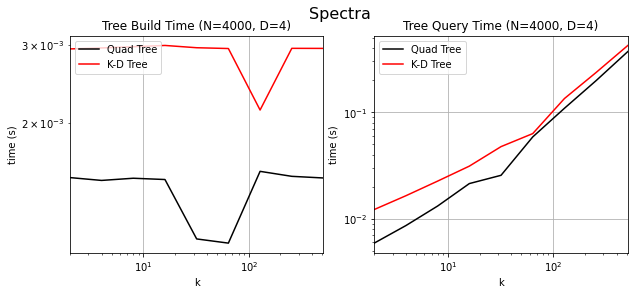

In [ ]:
k = 2 ** np.arange(1, 10)
for title, dataset in zip(titles, datasets_N):
    fig, ax = plot_scaling(dataset, N=4000, k=k, suptitle=title,
                           estimate_brute=True)


* Ίσως περιμένουμε γραμμική κλιμάκωση με k, αλλά για μεγάλα k αυτό δεν ισχύει
διότι πρέπει να διατηρηθεί μια ουρά προτεραιότητας των πλησιέστερων γειτόνων


* Παρόλο που ο χρόνος κατασκευής του Quad Tree είναι τρεις φορές μικρότερος, η απόλυτη διαφορά χρόνου είναι μικρότερη από δύο χιλιοστά του δευτερολέπτου. Αυτό οφείλεται στο γεγονός ότι το Quad Tree χρειάζεται χρόνο να συρρικνώσει τα όρια κάθε κόμβου.

**Κλιμάκωση με βάση τον αριθμό των σημείων**

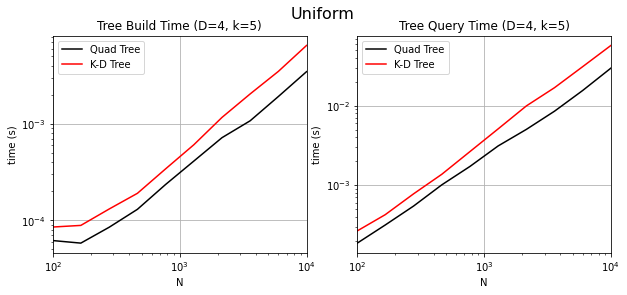

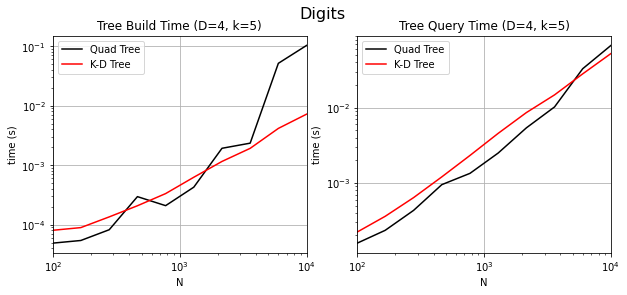

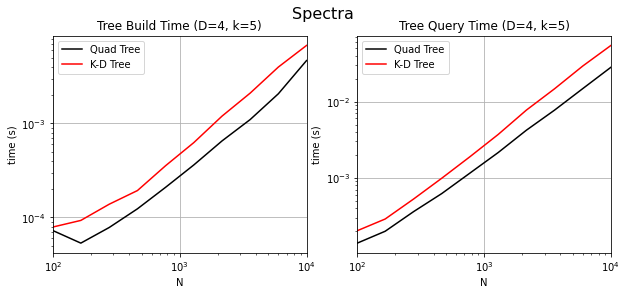

In [ ]:
N = (10 ** np.linspace(2, 4, 10)).astype(int)
for title, dataset in zip(titles, datasets_N):
    plot_scaling(dataset, N=N, estimate_brute=True, suptitle=title)

* Έχουμε ορίσει d = 4 και k = 5 σε κάθε περίπτωση για ευκολία σύγκρισης. Εξετάζοντας τα γραφήματα, βλέπουμε κάποια κοινά χαρακτηριστικά: όλοι οι αλγόριθμοι δενδρών φαίνεται να κλιμακώνονται με πολυπλοκότητα [NlogN]. 
* Επιπλέον παρατηρείται ότι και για αυτήν τη χαμηλή διάσταση, οι δύο μέθοδοι τείνουν να είναι ελαφρώς ταχύτερες για δομημένα δεδομένα από ό, τι για ομοιόμορφα δεδομένα. Παραδόξως, η απόδοση του Quad Tree επιδεινώνεται για πολύ δομημένα δεδομένα. Ίσως αυτό οφείλεται στη χρήση του κανόνα ολισθαίνοντος μέσου: λειτουργεί καλά για ομοιόμορφα κατανεμημένα δεδομένα, αλλά για πολύ δομημένα δεδομένα μπορεί να οδηγήσει σε καταστάσεις όπου υπάρχουν πολλοί πιο αραιοκατοικημένοι κόμβοι.